## 5. Modeling

In [38]:
import pandas as pd

In [39]:
credit_data = pd.read_csv('credit_record.csv')
app_data = pd.read_csv('application_record.csv')

STEP 1: CREATE TARGET LABELS
Created labels for 45,985 customers
Label
1    99.60%
0     0.40%
Name: Proportion, dtype: object

STEP 2: MERGE APPLICATION + CREDIT DATA
Merged dataset: 36,457 rows, 19 columns


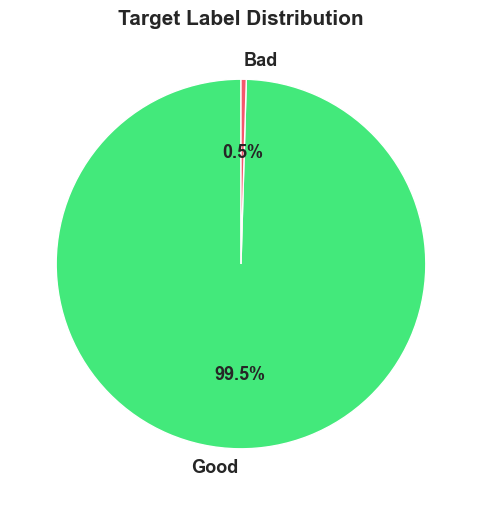


STEP 3: ENCODE CATEGORICAL FEATURES
Encoded features: 47 total columns

STEP 4: SMOTE + TOMEK LINKS BALANCING
Training set: (57902, 47), Test set: (7292, 47)

STEP 6: TRAINING XGBOOST MODEL
Model trained successfully

STEP 7: MODEL PERFORMANCE METRICS
Accuracy:  0.9942
Precision: 0.9959
Recall:    0.9983
F1-Score:  0.9971
ROC-AUC:   0.6198

Classification Report:
              precision    recall  f1-score   support

     Bad (0)       0.20      0.09      0.12        33
    Good (1)       1.00      1.00      1.00      7259

    accuracy                           0.99      7292
   macro avg       0.60      0.54      0.56      7292
weighted avg       0.99      0.99      0.99      7292



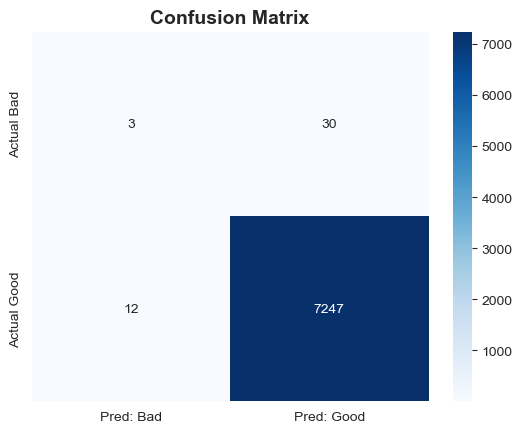

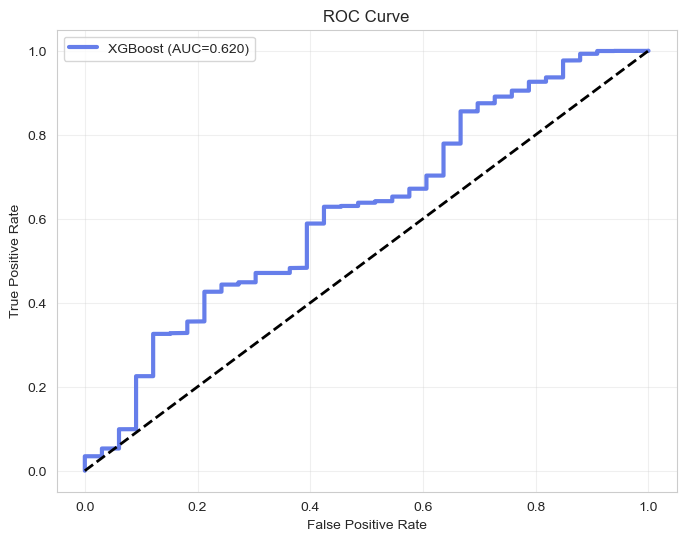


STEP 8: BUSINESS IMPACT ANALYSIS
Cost of missed bads: $90,000
Cost of rejected goods: $3,600
Total operational cost: $93,600

Baseline (approve all) cost: $99,000
Savings vs baseline: $5,400 (5.45% reduction)


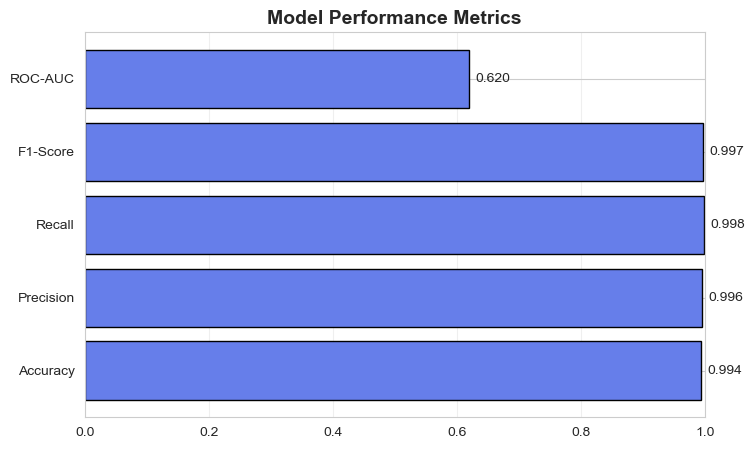

In [45]:
# 0. Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report
)
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import auc


# 1. CREATE GOOD/BAD LABEL FROM CREDIT RECORDS

print("="*80)
print("STEP 1: CREATE TARGET LABELS")
print("="*80)

credit_data['Good or Bad'] = credit_data['STATUS'].apply(
    lambda x: 'Good' if x in ['0', 'X', 'C'] else 'Bad'
)

# Group by ID and find dominant label
credit_goods_bads = credit_data.groupby(['ID', 'Good or Bad']).size().to_frame('size').reset_index()
idx = credit_goods_bads.groupby('ID')['size'].idxmax()
max_goods_bads = credit_goods_bads.loc[idx]

# Convert to binary
max_goods_bads['Label'] = max_goods_bads['Good or Bad'].apply(lambda x: 1 if x == 'Good' else 0)
max_goods_bads = max_goods_bads[['ID', 'Label']]

print(f"Created labels for {len(max_goods_bads):,} customers")
print(max_goods_bads['Label'].value_counts(normalize=True).rename('Proportion').apply(lambda x: f"{x*100:.2f}%"))


# 2. MERGE WITH APPLICATION DATA

print("\n" + "="*80)
print("STEP 2: MERGE APPLICATION + CREDIT DATA")
print("="*80)

app_data.fillna('Unknown', inplace=True)
data = pd.merge(app_data, max_goods_bads, on='ID', how='inner')

print(f"Merged dataset: {data.shape[0]:,} rows, {data.shape[1]} columns")

# Visualize target distribution
plt.figure(figsize=(6,6))
data['Label'].value_counts().plot.pie(
    labels=['Good', 'Bad'], autopct='%1.1f%%',
    colors=['#43e97b','#f5576c'], startangle=90,
    textprops={'fontsize':13,'fontweight':'bold'}
)
plt.title('Target Label Distribution', fontsize=15, weight='bold')
plt.ylabel('')
plt.show()


# 3. ENCODE CATEGORICAL FEATURES

print("\n" + "="*80)
print("STEP 3: ENCODE CATEGORICAL FEATURES")
print("="*80)

X = data.drop(['Label', 'ID'], axis=1)
y = data['Label']

X_encoded = pd.get_dummies(X, drop_first=True)
print(f"Encoded features: {X_encoded.shape[1]} total columns")


# 4. HANDLE IMBALANCE WITH SMOTE + TOMEK LINKS

print("\n" + "="*80)
print("STEP 4: SMOTE + TOMEK LINKS BALANCING")
print("="*80)

smote_tomek = SMOTETomek(random_state=42)


# 5. TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,                 
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


# 6. MODEL TRAINING (XGBOOST)

print("\n" + "="*80)
print("STEP 6: TRAINING XGBOOST MODEL")
print("="*80)

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
print("Model trained successfully")


# 7. MODEL EVALUATION

print("\n" + "="*80)
print("STEP 7: MODEL PERFORMANCE METRICS")
print("="*80)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bad (0)', 'Good (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Bad', 'Pred: Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='#667eea', lw=3, label=f'XGBoost (AUC={roc_auc_val:.3f})')
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 8. BUSINESS IMPACT ANALYSIS

print("\n" + "="*80)
print("STEP 8: BUSINESS IMPACT ANALYSIS")
print("="*80)

tn, fp, fn, tp = cm.ravel()

# Financial assumptions
avg_loss_bad = 3000    # loss if bad customer approved
avg_rev_good = 300     # revenue if good customer approved

cost_missed_bad = fp * avg_loss_bad       # false positive = bad labeled good
cost_rejected_good = fn * avg_rev_good    # false negative = good labeled bad
total_cost = cost_missed_bad + cost_rejected_good

total_bad = tn + fp
baseline_cost = total_bad * avg_loss_bad
savings = baseline_cost - total_cost

print(f"Cost of missed bads: ${cost_missed_bad:,.0f}")
print(f"Cost of rejected goods: ${cost_rejected_good:,.0f}")
print(f"Total operational cost: ${total_cost:,.0f}")
print(f"\nBaseline (approve all) cost: ${baseline_cost:,.0f}")
print(f"Savings vs baseline: ${savings:,.0f} ({savings/baseline_cost*100:.2f}% reduction)")

# Summary bar chart
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}
plt.figure(figsize=(8,5))
bars = plt.barh(list(metrics.keys()), list(metrics.values()), color='#667eea', edgecolor='black')
plt.xlim(0,1)
plt.title('Model Performance Metrics', fontsize=14, weight='bold')
for bar in bars:
    plt.text(bar.get_width()+0.01, bar.get_y()+bar.get_height()/2, f'{bar.get_width():.3f}', va='center')
plt.grid(alpha=0.3, axis='x')
plt.show()

In [12]:
# Validate with cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(xgb_model, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
print("Cross-validated AUC:", cv_auc.mean())

Cross-validated AUC: 0.9988054121013807


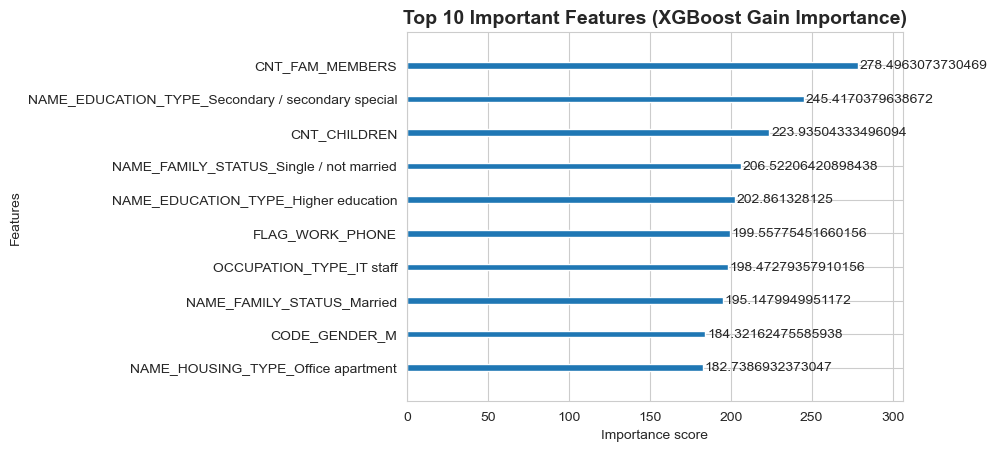

In [41]:
# Important Features
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (XGBoost Gain Importance)", fontsize=14, weight='bold')
plt.show()

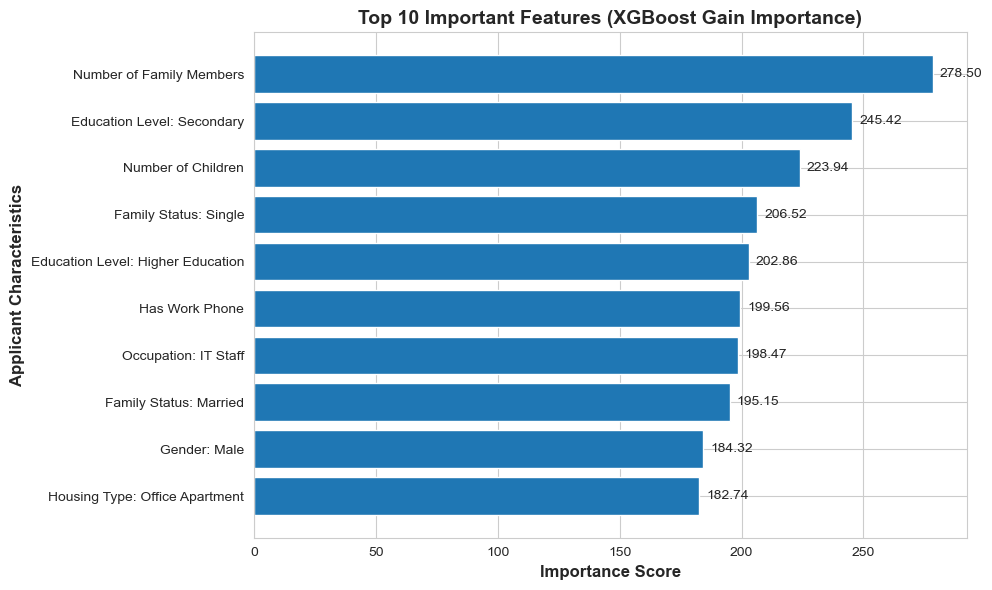

In [44]:
#Important Features
feature_name_map = {
    'CNT_FAM_MEMBERS': 'Number of Family Members',
    'CNT_CHILDREN': 'Number of Children',
    'CODE_GENDER_M': 'Gender: Male',
    'FLAG_WORK_PHONE': 'Has Work Phone',
    'NAME_FAMILY_STATUS_Single / not married': 'Family Status: Single',
    'NAME_FAMILY_STATUS_Married': 'Family Status: Married',
    'NAME_EDUCATION_TYPE_Higher education': 'Education Level: Higher Education',
    'NAME_EDUCATION_TYPE_Secondary / secondary special': 'Education Level: Secondary',
    'OCCUPATION_TYPE_IT staff': 'Occupation: IT Staff',
    'NAME_HOUSING_TYPE_Office apartment': 'Housing Type: Office Apartment'
}


importance = xgb_model.get_booster().get_score(importance_type='gain')

imp_df = (
    pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
      .sort_values(by='Importance', ascending=False)
      .head(10)
)

# Replace feature names with readable labels
imp_df['Feature'] = imp_df['Feature'].map(
    lambda x: feature_name_map.get(x, x)
)


plt.figure(figsize=(10, 6))
bars = plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.gca().invert_yaxis()


for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (imp_df['Importance'].max() * 0.01),
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}',
        va='center',
        fontsize=10
    )


plt.title("Top 10 Important Features (XGBoost Gain Importance)", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12, fontweight='bold')
plt.ylabel("Applicant Characteristics", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()